In [2]:
import numpy as np
import pandas as pd
import torch
# read MNIST training data
def LoadData(path):
    df = pd.read_csv(path)
    X = df.iloc[:, 1:].to_numpy() / 255.0       # values are scaled to be between 0 and 1
    y = df.iloc[:, 0].to_numpy()                # labels of images
    X=torch.tensor(X)
    y=torch.tensor(y)
    X=X.view(len(y),1, 28, 28)
    print("X.shape=",X.size())
    X=X.to(torch.float32)
    #y=y.to(torch.float32)
    return X,y

In [4]:
path='./data/mnist_train.csv'
testpath='./data/mnist_test.csv'
X, y = LoadData(path)
X_test, y_test = LoadData(testpath)
print(X.dtype)
from torch.utils.data import Dataset, TensorDataset, DataLoader
train_dataset = TensorDataset(X, y)
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)

X.shape= torch.Size([60000, 1, 28, 28])
X.shape= torch.Size([10000, 1, 28, 28])
torch.float32


In [25]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import random

# Define the CNN autoencoder model
class CNN_Autoencoder(nn.Module):
    def __init__(self):
        super(CNN_Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),  # Conv2D layer with SELU activation (28+2-3)/1+1=28
            nn.SELU(),
            nn.MaxPool2d(2, 2),  # MaxPool2D layer (28-2)/2+1=14
            nn.Conv2d(16, 32, 3, padding=1),#14-3+2+1=14
            nn.SELU(),
            nn.MaxPool2d(2, 2),#14-2/2+1=7
            nn.Conv2d(32, 64, 3, padding=1),
            nn.SELU(),
            nn.MaxPool2d(2, 2)#7-2/2+1=2+1=3
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, stride=2),  # Transposed Conv2D layer  o=s(i-1)-2p+k  (3-1)*2+3=7
            nn.SELU(),
            nn.ConvTranspose2d(32, 16, 2, stride=2),
            nn.SELU(),
            nn.ConvTranspose2d(16, 1, 2, stride=2),
            nn.Sigmoid()  # Using sigmoid for the output layer
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Initialize the CNN autoencoder model
cnn_autoencoder = CNN_Autoencoder()
from torchsummary import summary
summary(cnn_autoencoder,(1,28,28),batch_size=1,device="cpu")
# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(cnn_autoencoder.parameters(), lr=0.001)


# Training loop
num_epochs = 10
train_losses = []
for epoch in range(num_epochs):
    for data in train_loader:
        images, _ = data
        optimizer.zero_grad()
        outputs = cnn_autoencoder(images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')
    train_losses.append(loss.item())
# Save the trained CNN autoencoder model
torch.save(cnn_autoencoder.state_dict(), 'cnn_autoencoder_model.pth')


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [1, 16, 28, 28]             160
              SELU-2            [1, 16, 28, 28]               0
         MaxPool2d-3            [1, 16, 14, 14]               0
            Conv2d-4            [1, 32, 14, 14]           4,640
              SELU-5            [1, 32, 14, 14]               0
         MaxPool2d-6              [1, 32, 7, 7]               0
            Conv2d-7              [1, 64, 7, 7]          18,496
              SELU-8              [1, 64, 7, 7]               0
         MaxPool2d-9              [1, 64, 3, 3]               0
  ConvTranspose2d-10              [1, 32, 7, 7]          18,464
             SELU-11              [1, 32, 7, 7]               0
  ConvTranspose2d-12            [1, 16, 14, 14]           2,064
             SELU-13            [1, 16, 14, 14]               0
  ConvTranspose2d-14             [1, 1,

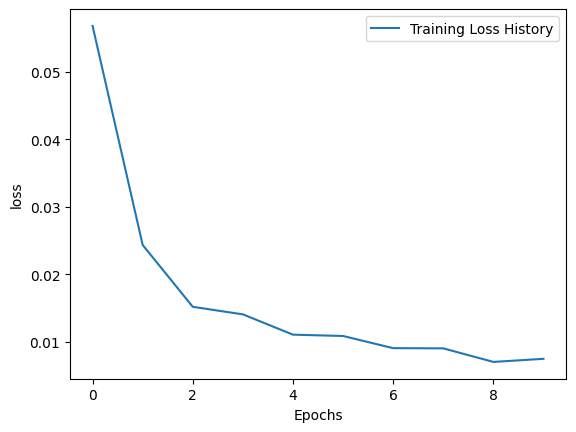

In [26]:
import matplotlib.pyplot as plt
def plotLossHistory(train_losses):
    plt.figure()
    plt.plot(range(len(train_losses)), train_losses, label='Training Loss History')
    plt.xlabel('Epochs')
    plt.ylabel('loss')
    plt.legend()
plotLossHistory(train_losses)

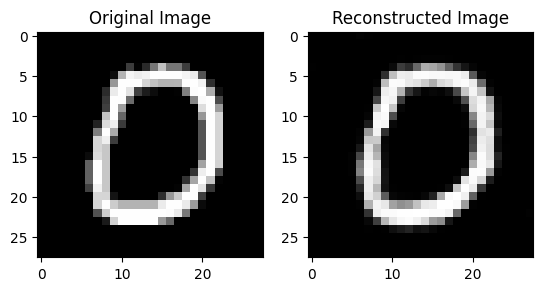

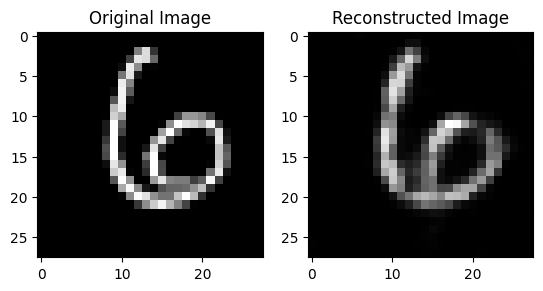

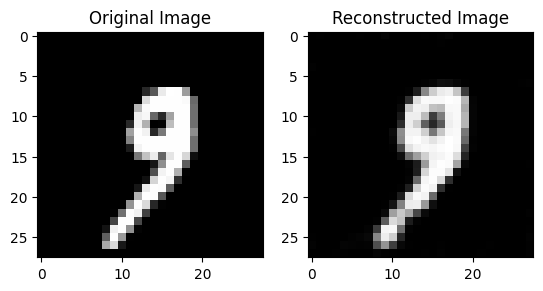

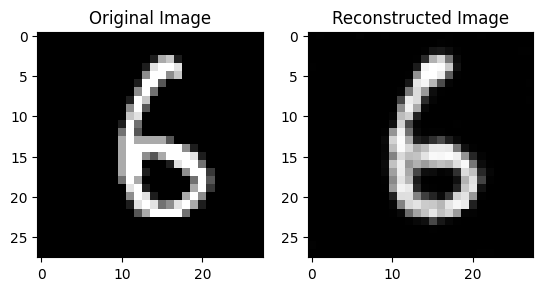

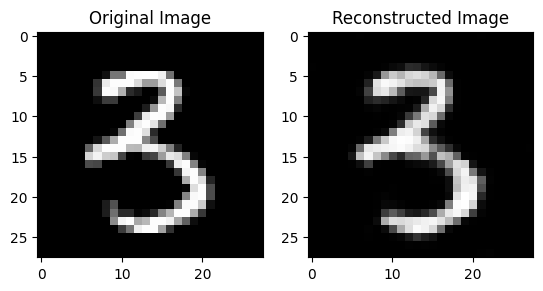

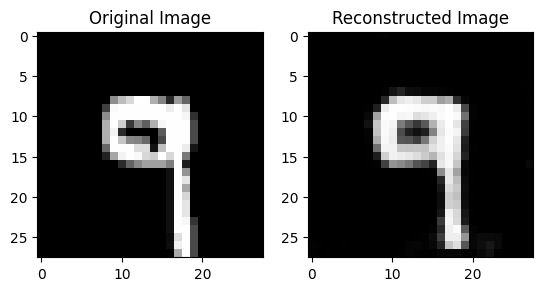

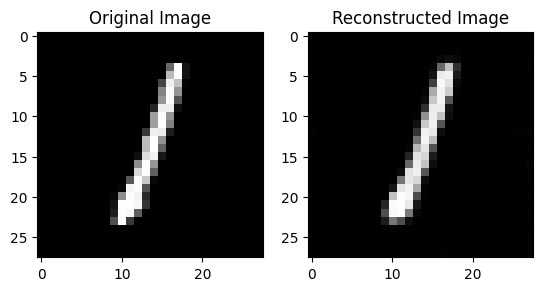

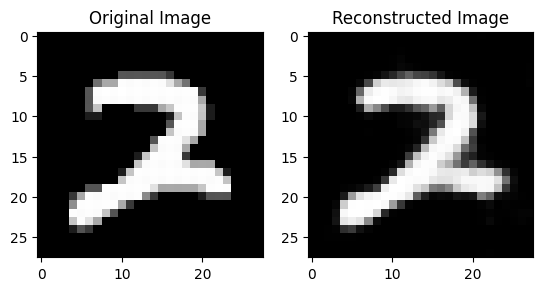

In [28]:
import torch
import torchvision
import matplotlib.pyplot as plt
import random

# Load the MNIST dataset for testing

# Load the trained autoencoder model
cnn_autoencoder.load_state_dict(torch.load('cnn_autoencoder_model.pth'))
cnn_autoencoder.eval()

# Randomly choose a few examples for reconstruction
num_examples = 8
examples = [10,100,1000,3000,5000,6000,7000,9500]

# Reconstruct and display the chosen examples
with torch.no_grad():
    for example_idx in examples:
        original_image, _ = test_dataset[example_idx]
        #original_image = original_image.view(1, -1)
        reconstructed_image = cnn_autoencoder(original_image)

        # Reshape the reconstructed image to its original shape (e.g., 28x28)
        reconstructed_image = reconstructed_image.view(28, 28)

        plt.figure()
        plt.subplot(1, 2, 1)
        plt.title('Original Image')
        plt.imshow(original_image.view(28, 28).numpy(), cmap='gray')

        plt.subplot(1, 2, 2)
        plt.title('Reconstructed Image')
        plt.imshow(reconstructed_image.numpy(), cmap='gray')

        plt.show()
